In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import FinanceDataReader as fdr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
import pandas_ta as ta

warnings.filterwarnings('ignore')

In [2]:
def Merge_NT(input_df):
    naver_trend_df=pd.read_csv("naver_trend.csv")
    naver_trend_df=naver_trend_df[6:]
    naver_trend_df=naver_trend_df.reset_index(drop=True)
    naver_trend_df.columns = ['Date', 'trend_index']
    naver_trend_df['Date'] = pd.to_datetime(naver_trend_df['Date'], format="%Y-%m-%d")
    input_df=pd.merge(input_df,naver_trend_df,on='Date')
    return input_df

def Merge_pandas_ta(input_df):
    adx = input_df.ta.adx()
    macd = input_df.ta.macd(fast=14, slow=24)
    rsi = input_df.ta.rsi()
    df = pd.concat([input_df, adx, macd, rsi], axis=1)
    #결측치 처리
    predict_df = df
    predict_df2 = predict_df.dropna(axis=1, how='all')
    predict_df3 = predict_df2.interpolate(method='values')
    predict_df4 = predict_df3.dropna(axis=0, how='any')
    predict_df5 = predict_df4.drop(['High', 'Low'], axis=1)
    input_df=predict_df5
    return input_df

def Merge_DJI(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    DJI_df = fdr.DataReader('dji', start_date, end_date).reset_index()
    dji_df=DJI_df.drop(['Open','High','Low','Change'],axis=1)
    dji_df.rename({'Close':'dji_c','Volume':'dji_v'},axis=1,inplace=True)
    input_df=pd.merge(input_df,dji_df,how='outer',on='Date')
    
    return input_df

def Merge_ECR(input_df):
    start_date = str(input_df['Date'].iloc[0])
    end_date = str(input_df['Date'].iloc[-1])
    exr=fdr.DataReader('USD/KRW', start_date, end_date).reset_index()
    exr=exr.drop(['Open','High','Low','Change'],axis=1)
    exr.rename({'Close':'exc_c'},axis=1,inplace=True)
    input_df=pd.merge(input_df,exr,how='outer',on='Date')
    input_df=input_df.fillna(method='ffill')
    input_df=input_df.fillna(method='bfill')
    
    return input_df

def Merge_hr(input_df):
    HR_3y_df=pd.read_csv("hash-rate_3y.csv")
    HR_all_df=pd.read_csv("hash-rate_alltime.csv")
    HR_df=HR_all_df.iloc[715:1255]
    HR_df=pd.concat([HR_df,HR_3y_df])
    a=pd.date_range(start=str(input_df['Date'].iloc[0]),end=str(input_df['Date'].iloc[-1]))
    HR_ori_df=pd.DataFrame(a)
    HR_ori_df.rename({0:'Timestamp'},axis=1,inplace=True)
    
    for i in range(len(HR_ori_df['Timestamp'])):
        HR_ori_df['Timestamp'].iloc[i]=str(HR_ori_df['Timestamp'].iloc[i])
        
    HR_ori_df=pd.merge(HR_ori_df,HR_df,how='outer',on='Timestamp')
    HR_ori_df=HR_ori_df[:len(a)+1]
    HR_ori_df=HR_ori_df.drop_duplicates()
    HR_ori_df=HR_ori_df.fillna(method='ffill')
    HR_ori_df=HR_ori_df.fillna(method='bfill')
    HR_ori_df.rename({'Timestamp':'Date'},axis=1,inplace=True)
    
    for i in range(len(input_df['Date'])):
        input_df['Date'].iloc[i]=str(input_df['Date'].iloc[i])
        
    input_df=pd.merge(input_df,HR_ori_df,how='outer',on='Date')
    
    return input_df

def preprocessing(input_df, len_lag) :
    # 이동평균선 추가 5,10,20
    moving_avg=[5,10,20]
    for i in moving_avg:
        input_df[f'{i}_close']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'{i}_close']=input_df['Close'].rolling(window=i).mean()
        
    # p_lag:과거 가격, q_lag:과거 거래량 추가, pq_lag:거래대금 
    for lag in range(1,len_lag+1):
        input_df[f'p_lag_{lag}'] = -1
        input_df[f'q_lag_{lag}'] = -1 
        input_df[f'pq_lag_{lag}'] = -1
        for index in range(lag, len(input_df)):
            input_df.loc[index, f'p_lag_{lag}'] = input_df['Close'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            input_df.loc[index, f'q_lag_{lag}'] = input_df['Volume'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
            input_df.loc[index, f'pq_lag_{lag}'] = (input_df['Close'][index-lag]*input_df['Volume'][index-lag]) #1일전, 2일전, ... 거래량을 feature로 추가
            
def OBV_preprocessing(input_df):
    # OBV 산출 및 데이터 프레임에 추가 
    OBV=[]
    OBV.append(0)
    for i in range(1,len(input_df)):
        if input_df['Close'].iloc[i] > input_df['Close'].iloc[i-1]:
            OBV.append(OBV[-1]+input_df['Volume'].iloc[i])
        elif price_df['Close'].iloc[i]<input_df['Close'].iloc[i-1]:
            OBV.append(OBV[-1]-input_df['Volume'].iloc[i]) 
        else:
            OBV.append(OBV[-1])
            
    # OBV 추가
    input_df['obv']=OBV
    
    # 지수 평균 이동값 계산 
    input_df['obv_ema']=input_df['obv'].ewm(com=20).mean()
    
    # obv가 보통 지수를 위로 뚫으면 매수 신호 아래로 뚫으면 매도 신호 
    input_df['signal_obv']=input_df['obv']-input_df['obv_ema']
    
    moving_avg=[5,20,30]
    for i in moving_avg:
        input_df[f'obv_lag{i}']=-1
    for index in range(len(input_df)):
        for i in moving_avg:
            input_df[f'obv_lag{i}']=input_df['signal_obv'].rolling(window=i).mean()

def gen_train_test2(input_df):
    input_df['target']=0
    for i in range(len(input_df)-1):
        input_df['target'].iloc[i]=input_df['Close'].iloc[i+1]
        
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]

        

def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])

    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    return df

        


def backtest_XGB_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1시간 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # print(f'{idx}/{total_loop} running loop...')
            train, test = batch_df[:ft-1], batch_df[ft-1:ft]
            X_train, y_train = train.drop('target',axis=1,inplace=False),train['target']
            X_test, y_test = test.drop('target',axis=1,inplace=False),test['target']
            xgb = XGBRegressor()
            xgb.fit(X_train, y_train)
            pred = xgb.predict(X_test)
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].Open
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['Close'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    l=list(df.index)
    for i in range(len(l)):
        l[i]=datetime.strptime(str(l[i])[:10],'%Y-%m-%d')
    plt.plot(l, df['Close'].values, color='b', label='real close')
    plt.plot(l, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    l=list(df.index)
    for i in range(len(l)):
        l[i]=datetime.strptime(str(l[i])[:10],'%Y-%m-%d')
    plt.plot(l, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()


def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

In [3]:
with open("btc_usd_1d.pkl", "rb") as f:
    df = pickle.load(f)
df.reset_index(inplace=True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df.set_index('Date', inplace=True)

In [4]:
df.ta.strategy("Momentum")

39it [00:02, 14.40it/s]


In [5]:
predict_df = df
predict_df['target'] = predict_df['Close'].shift(-1)
predict_df = predict_df[:-1]
predict_df

,Open,High,Low,Close,Volume,AO_5_34,APO_12_26,BIAS_SMA_26,BOP,AR_26,...,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,target
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06,NaN,NaN,NaN,0.020906,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,373.34
2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06,NaN,NaN,NaN,-0.372549,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,378.39
2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06,NaN,NaN,NaN,0.214440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,379.25
2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06,NaN,NaN,NaN,0.112713,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376.67
2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06,NaN,NaN,NaN,-0.294185,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,365.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,42378.23,42589.90,41145.23,41683.21,1.664704e+03,-3197.149147,-2287.377949,-0.069796,-0.481093,60.827977,...,39.179757,60.347535,69.711019,-0.428430,-0.407445,-26.296567,-25.551853,50.066401,-56.621761,40736.05
2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03,-3272.737588,-1993.623718,-0.083296,-0.336361,64.431421,...,37.620526,47.354520,60.262539,-0.432786,-0.413215,-27.679742,-25.855838,45.557461,-75.960871,36495.46
2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03,-3989.753882,-1892.149679,-0.168435,-0.730646,55.707374,...,33.465707,24.370841,44.024299,-0.439363,-0.418819,-32.568390,-26.814774,36.436322,-88.127758,35091.11


In [6]:
#결측치 처리
predict_df2 = predict_df.dropna(axis=1, how='all')
predict_df2 = predict_df2[40:]

predict_df3 = predict_df2.interpolate(method='values')
predict_df4 = predict_df3.dropna(axis=0, how='any')
predict_df5 = predict_df4.drop(['High', 'Low'], axis=1)

In [7]:
col_dict = predict_df5.columns
col_dict

Index(['Open', 'Close', 'Volume', 'AO_5_34', 'APO_12_26', 'BIAS_SMA_26', 'BOP',
       'AR_26', 'BR_26', 'CCI_14_0.015', 'CFO_9', 'CG_10', 'CMO_14',
       'COPC_11_14_10', 'CTI_12', 'ER_10', 'BULLP_13', 'BEARP_13',
       'FISHERT_9_1', 'FISHERTs_9_1', 'INERTIA_20_14', 'K_9_3', 'D_9_3',
       'J_9_3', 'KST_10_15_20_30_10_10_10_15', 'KSTs_9', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'MOM_10', 'PGO_14', 'PPO_12_26_9',
       'PPOh_12_26_9', 'PPOs_12_26_9', 'PSL_12', 'PVO_12_26_9', 'PVOh_12_26_9',
       'PVOs_12_26_9', 'QQE_14_5_4.236', 'QQE_14_5_4.236_RSIMA',
       'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'ROC_10', 'RSI_14', 'RSX_14',
       'RVGI_14_4', 'RVGIs_14_4', 'SLOPE_1', 'SMI_5_20_5', 'SMIs_5_20_5',
       'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZ_ON', 'SQZ_OFF', 'SQZ_NO',
       'SQZPRO_20_2.0_20_2_1.5_1', 'SQZPRO_ON_WIDE', 'SQZPRO_ON_NORMAL',
       'SQZPRO_ON_NARROW', 'SQZPRO_OFF', 'SQZPRO_NO', 'STC_10_12_26_0.5',
       'STCmacd_10_12_26_0.5', 'STCstoch_10_12_

In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
data = predict_df5[col_dict[:-1]]
target = predict_df5['target']
x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, shuffle=False)

model = XGBRegressor()
xgb = model.fit(x_train, y_train)
y_pred = model.predict(x_valid)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

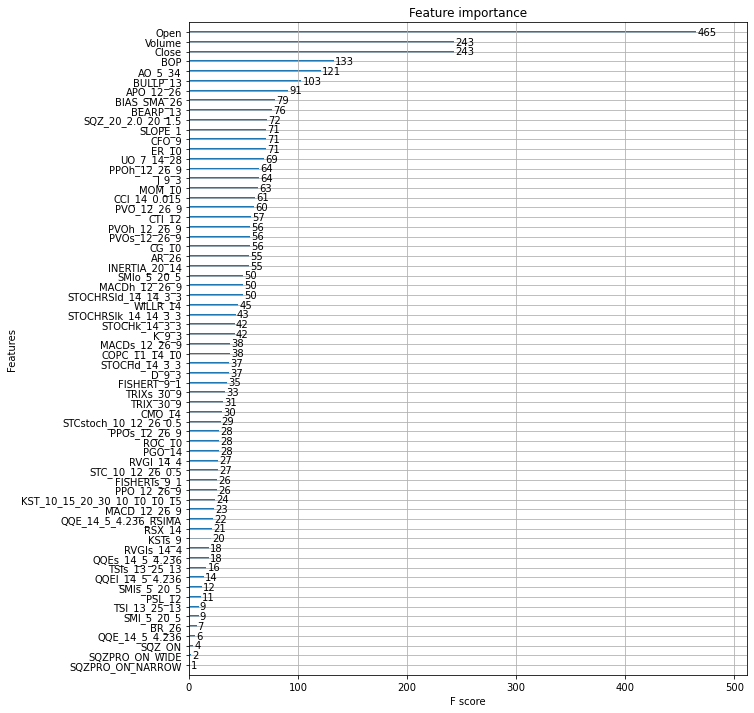

In [9]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb, ax=ax)

In [10]:
predict_df5

,Open,Close,Volume,AO_5_34,APO_12_26,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,...,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,target
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-20,217.84,211.08,2.998319e+06,-72.501559,-38.749808,-0.208808,-0.426230,62.153659,62.997911,-53.731687,...,43.559731,98.375630,97.703118,-0.467671,-0.332447,-39.866662,-43.304159,40.477963,-52.829582,228.59
2015-01-21,211.08,228.59,4.937625e+06,-68.337912,-38.833077,-0.130351,0.732636,62.991547,64.035058,-26.364283,...,48.700742,98.375630,98.136427,-0.498590,-0.364767,-36.188678,-42.287661,53.002499,-38.754019,233.00
2015-01-22,228.59,233.00,6.003089e+06,-59.954088,-39.295000,-0.102690,0.339492,70.412316,71.443190,7.312296,...,53.190414,98.375630,98.375630,-0.526695,-0.397592,-32.789021,-40.930713,51.610038,-35.209003,233.03
2015-01-23,233.00,233.03,3.539627e+06,-52.395647,-39.727115,-0.091322,0.002076,70.893352,71.912782,17.974847,...,58.256520,100.000000,98.917087,-0.552093,-0.429809,-30.107283,-39.384508,53.866337,-35.184887,249.99
2015-01-24,233.03,249.99,3.297573e+06,-44.732059,-38.749359,-0.015623,0.849699,76.146271,77.157235,62.127941,...,63.568239,100.000000,99.458543,-0.573501,-0.460757,-25.878665,-37.455102,60.732704,-21.551447,253.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,42378.23,41683.21,1.664704e+03,-3197.149147,-2287.377949,-0.069796,-0.481093,60.827977,60.837847,-67.316987,...,39.179757,60.347535,69.711019,-0.428430,-0.407445,-26.296567,-25.551853,50.066401,-56.621761,40736.05
2022-01-20,41733.21,40736.05,2.425153e+03,-3272.737588,-1993.623718,-0.083296,-0.336361,64.431421,64.616778,-78.505332,...,37.620526,47.354520,60.262539,-0.432786,-0.413215,-27.679742,-25.855838,45.557461,-75.960871,36495.46
2022-01-21,40654.72,36495.46,6.201046e+03,-3989.753882,-1892.149679,-0.168435,-0.730646,55.707374,55.601598,-319.110076,...,33.465707,24.370841,44.024299,-0.439363,-0.418819,-32.568390,-26.814774,36.436322,-88.127758,35091.11


In [11]:
gen_train_test2(predict_df5)
final_price_df=predict_df5
final_price_df

,Open,Close,Volume,AO_5_34,APO_12_26,BIAS_SMA_26,BOP,AR_26,BR_26,CCI_14_0.015,...,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14,target
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-20,217.84,211.08,2.998319e+06,-72.501559,-38.749808,-0.208808,-0.426230,62.153659,62.997911,-53.731687,...,43.559731,98.375630,97.703118,-0.467671,-0.332447,-39.866662,-43.304159,40.477963,-52.829582,228.59
2015-01-21,211.08,228.59,4.937625e+06,-68.337912,-38.833077,-0.130351,0.732636,62.991547,64.035058,-26.364283,...,48.700742,98.375630,98.136427,-0.498590,-0.364767,-36.188678,-42.287661,53.002499,-38.754019,233.00
2015-01-22,228.59,233.00,6.003089e+06,-59.954088,-39.295000,-0.102690,0.339492,70.412316,71.443190,7.312296,...,53.190414,98.375630,98.375630,-0.526695,-0.397592,-32.789021,-40.930713,51.610038,-35.209003,233.03
2015-01-23,233.00,233.03,3.539627e+06,-52.395647,-39.727115,-0.091322,0.002076,70.893352,71.912782,17.974847,...,58.256520,100.000000,98.917087,-0.552093,-0.429809,-30.107283,-39.384508,53.866337,-35.184887,249.99
2015-01-24,233.03,249.99,3.297573e+06,-44.732059,-38.749359,-0.015623,0.849699,76.146271,77.157235,62.127941,...,63.568239,100.000000,99.458543,-0.573501,-0.460757,-25.878665,-37.455102,60.732704,-21.551447,253.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,42378.23,41683.21,1.664704e+03,-3197.149147,-2287.377949,-0.069796,-0.481093,60.827977,60.837847,-67.316987,...,39.179757,60.347535,69.711019,-0.428430,-0.407445,-26.296567,-25.551853,50.066401,-56.621761,40736.05
2022-01-20,41733.21,40736.05,2.425153e+03,-3272.737588,-1993.623718,-0.083296,-0.336361,64.431421,64.616778,-78.505332,...,37.620526,47.354520,60.262539,-0.432786,-0.413215,-27.679742,-25.855838,45.557461,-75.960871,36495.46
2022-01-21,40654.72,36495.46,6.201046e+03,-3989.753882,-1892.149679,-0.168435,-0.730646,55.707374,55.601598,-319.110076,...,33.465707,24.370841,44.024299,-0.439363,-0.418819,-32.568390,-26.814774,36.436322,-88.127758,35091.11


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import FinanceDataReader as fdr
import pandas_ta as ta
import os 
import pickle
import xgboost

2461it [07:17,  5.62it/s]


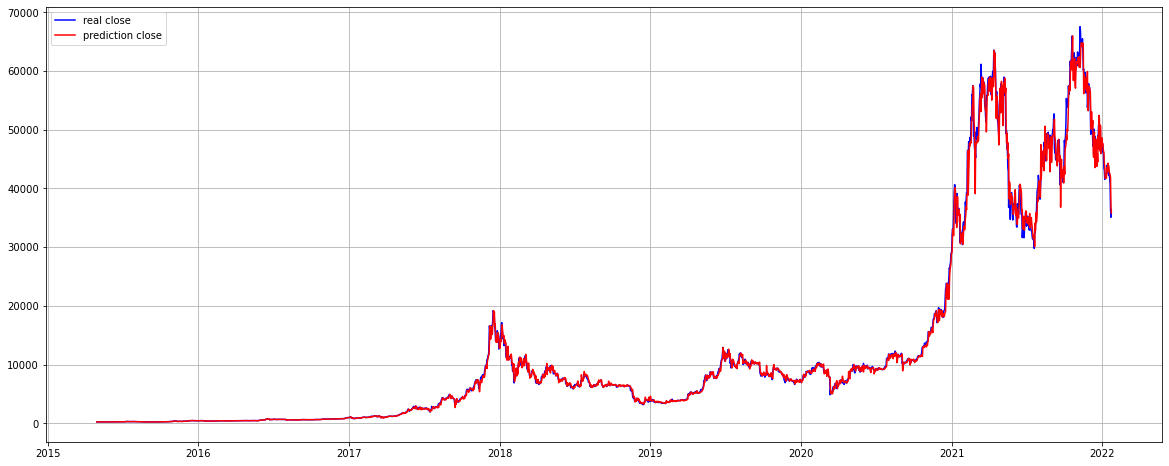

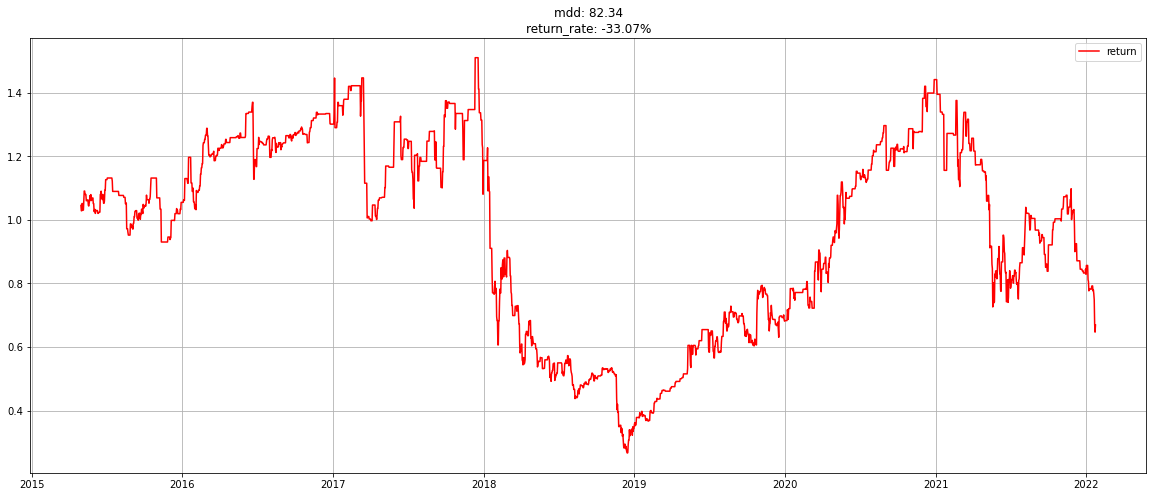

In [13]:
result_df = backtest_XGB_1d(final_price_df,100, 1)

2261it [12:28,  3.02it/s]


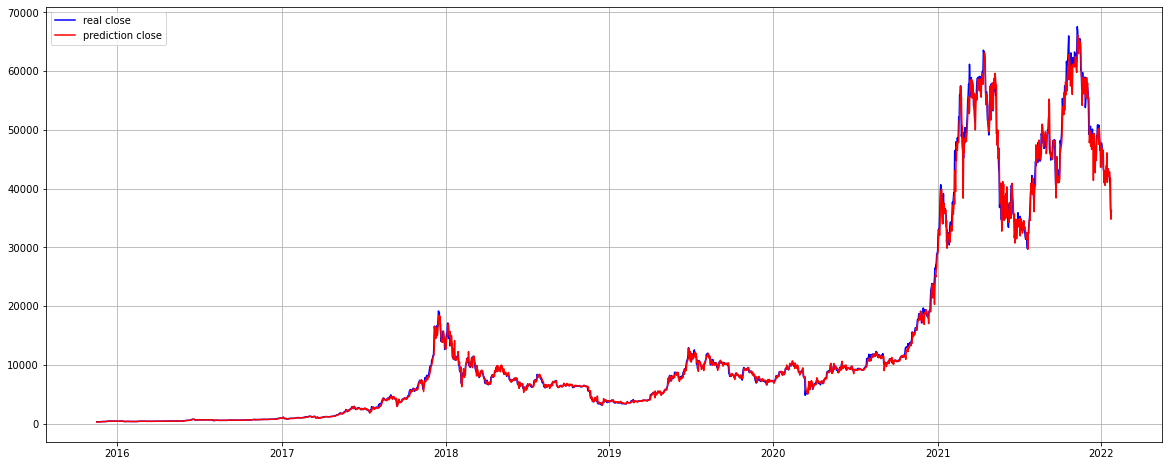

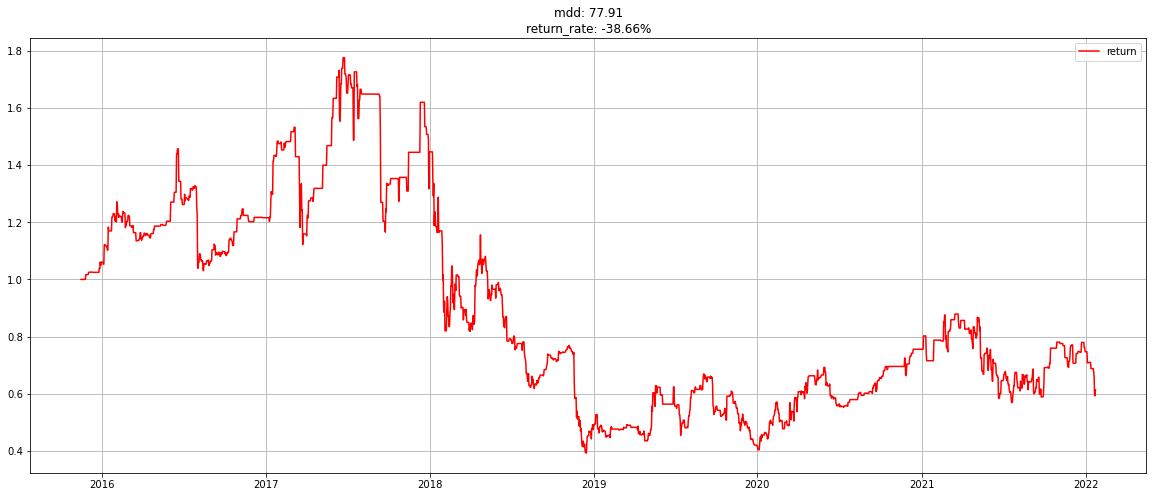

In [14]:
result_df = backtest_XGB_1d(final_price_df,300, 1)

In [199]:
with open("btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    df=df.reset_index()
    df.rename({'ot':'Date','o':'Open','h':'High','l':'Low','c':'Close','v':'Volume'},axis=1,inplace=True)
df

,Date,Open,High,Low,Close,Volume
0,2014-11-29,376.42,386.60,372.25,376.72,2.746157e+06
1,2014-11-30,376.57,381.99,373.32,373.34,1.145567e+06
2,2014-12-01,376.40,382.31,373.03,378.39,2.520662e+06
3,2014-12-02,378.39,382.86,375.23,379.25,2.593576e+06
4,2014-12-03,379.25,383.00,374.23,376.67,2.998358e+06
...,...,...,...,...,...,...
2609,2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03
2610,2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03
2611,2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03
2612,2022-01-23,35084.79,36574.47,34624.59,36293.62,2.533704e+03


In [200]:
naver_trend_df=pd.read_csv("naver_trend.csv")
naver_trend_df=naver_trend_df[6:]
naver_trend_df=naver_trend_df.reset_index(drop=True)
naver_trend_df.columns = ['Date', 'trend_index']
naver_trend_df['Date'] = pd.to_datetime(naver_trend_df['Date'], format="%Y-%m-%d")
naver_trend_df['trend_index']=pd.to_numeric(naver_trend_df['trend_index'])
df=pd.merge(df,naver_trend_df,on='Date')

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2215
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2216 non-null   datetime64[ns]
 1   Open         2216 non-null   float64       
 2   High         2216 non-null   float64       
 3   Low          2216 non-null   float64       
 4   Close        2216 non-null   float64       
 5   Volume       2216 non-null   float64       
 6   trend_index  2216 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 138.5 KB


In [202]:
df

,Date,Open,High,Low,Close,Volume,trend_index
0,2016-01-01,430.89,436.00,427.20,434.98,1.617803e+06,0.04181
1,2016-01-02,434.87,435.99,430.42,433.74,1.260194e+06,0.04777
2,2016-01-03,433.20,434.09,424.06,430.85,1.930487e+06,0.04528
3,2016-01-04,430.79,435.86,428.44,433.97,2.467177e+06,0.06150
4,2016-01-05,434.17,435.39,429.50,431.89,1.668756e+06,0.06184
...,...,...,...,...,...,...,...
2211,2022-01-20,41733.21,43518.69,40554.14,40736.05,2.425153e+03,2.48318
2212,2022-01-21,40654.72,41115.58,35423.00,36495.46,6.201046e+03,5.74564
2213,2022-01-22,36447.37,36825.98,34000.00,35091.11,4.510372e+03,9.47357
2214,2022-01-23,35084.79,36574.47,34624.59,36293.62,2.533704e+03,6.03637
